In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("analisis_elecciones").getOrCreate()

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.functions import sum
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 30)
sns.set()

---
# Dataset Elecciones PASO 2023

In [4]:
paso_original = spark.read.csv('ResultadosElectorales_PASO.csv', header=True, inferSchema=True)
paso = paso_original

In [5]:
paso.show(5)

+----+-------------+-------------+-----------+-----------+---------------+--------------------+------------------------+----------+--------------+-----------+---------------+-------+---------+--------------+--------+------------+-------------+--------------------+------------+--------------------+----------+--------------+
| año|eleccion_tipo|recuento_tipo|padron_tipo|distrito_id|distrito_nombre|seccionprovincial_id|seccionprovincial_nombre|seccion_id|seccion_nombre|circuito_id|circuito_nombre|mesa_id|mesa_tipo|mesa_electores|cargo_id|cargo_nombre|agrupacion_id|   agrupacion_nombre|lista_numero|        lista_nombre|votos_tipo|votos_cantidad|
+----+-------------+-------------+-----------+-----------+---------------+--------------------+------------------------+----------+--------------+-----------+---------------+-------+---------+--------------+--------+------------+-------------+--------------------+------------+--------------------+----------+--------------+
|2023|         PASO|   PR

In [6]:
partidos = [
    'NULO',
    'JUNTOS POR EL CAMBIO',
    'HACEMOS POR NUESTRO PAIS',
    'LA LIBERTAD AVANZA',
    'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD',
    'UNION POR LA PATRIA'
]

# Los espacion None los relleno con NULO
paso = paso.fillna({'agrupacion_nombre':'NULO'})

# Me dejo los registros unicamente si la agrupacón esta dentro de los 5 partidos principales y que sean cargos de PRESIDENTE
paso_filtered = paso.filter((paso["agrupacion_nombre"].isin(partidos)) & (paso['cargo_nombre'] == 'PRESIDENTE/A'))

In [7]:
# Comprobación de que no hay mas nulos
paso.filter(paso['agrupacion_nombre'].isNull()).count()

0

In [8]:
cantidad_votos_provincia_paso = paso_filtered.groupBy(
    ['distrito_nombre', 'agrupacion_nombre']).sum().select(
        ['distrito_nombre','agrupacion_nombre','sum(votos_cantidad)'])

cantidad_votos_provincia_paso = cantidad_votos_provincia_paso.toPandas()

In [8]:
palette = {
    'NULO': '#d3d1cb',  # Color para etiqueta 'None'
    'JUNTOS POR EL CAMBIO': '#fae72c',
    'HACEMOS POR NUESTRO PAIS': '#4ac138',
    'LA LIBERTAD AVANZA': '#cda6f0',
    'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD': '#ff8986',
    'UNION POR LA PATRIA': '#54d5eb'
}

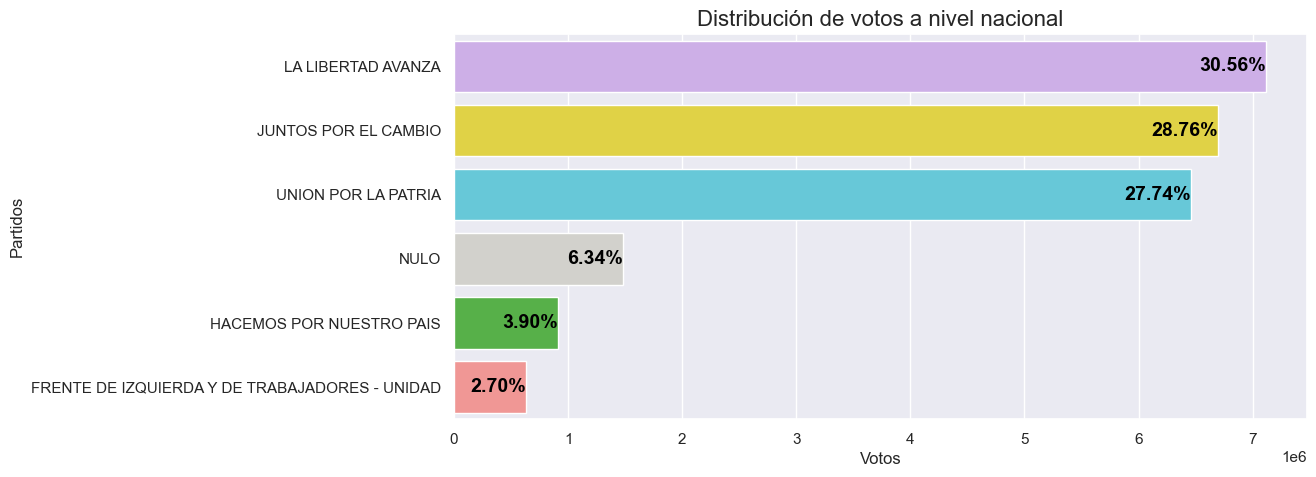

In [9]:
plt.figure(figsize=(11,5))



# Calcula los porcentajes
data = cantidad_votos_provincia_paso.groupby('agrupacion_nombre').sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
total_votos_provincia = data['sum(votos_cantidad)'].sum()
data['porcentaje'] = round((data['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)


ax = sns.barplot(data = data,
            x = 'sum(votos_cantidad)',
            y = 'agrupacion_nombre',
            errorbar=None, # en vez de ci=None,
            palette = palette)

# Agrega los porcentajes en las barras
for index, row in data.iterrows():
    porcentaje = row['porcentaje']
    ax.text(row['sum(votos_cantidad)'], index, f'{porcentaje:.2f}%', ha='right',va='center', fontsize=14, color='black', weight='bold')

plt.title('Distribución de votos a nivel nacional', fontsize=16)
plt.xlabel('Votos')
plt.ylabel('Partidos')
plt.show()

### Distribución de votos en las 5 provincias principales del pais.

In [10]:
cantidad_votos_provincia_paso.groupby(['distrito_nombre']).sum().sort_values(by=['sum(votos_cantidad)'], ascending=False).head(5)

,agrupacion_nombre,sum(votos_cantidad)
distrito_nombre,,
Buenos Aires,UNION POR LA PATRIANULOFRENTE DE IZQUIERDA Y D...,8623697
Córdoba,UNION POR LA PATRIAJUNTOS POR EL CAMBIOLA LIBE...,2033781
Santa Fe,JUNTOS POR EL CAMBIOUNION POR LA PATRIANULOLA ...,1825910
Ciudad Autónoma de Buenos Aires,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD...,1648396
Mendoza,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD...,1019805


In [11]:
provincias_principales = cantidad_votos_provincia_paso.groupby(['distrito_nombre']).sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index().distrito_nombre.head(5).to_list()
provincias_principales

['Buenos Aires',
 'Córdoba',
 'Santa Fe',
 'Ciudad Autónoma de Buenos Aires',
 'Mendoza']

In [12]:
cantidad_votos_provincia_paso[cantidad_votos_provincia_paso['distrito_nombre'].isin(provincias_principales)].groupby(['distrito_nombre','agrupacion_nombre']).sum().sort_values(by='sum(votos_cantidad)', ascending=False)

sum(votos_cantidad)
distrito_nombre                 agrupacion_nombre                                                  
Buenos Aires                    UNION POR LA PATRIA                                         2831078
                                JUNTOS POR EL CAMBIO                                        2567840
                                LA LIBERTAD AVANZA                                          2161679
Ciudad Autónoma de Buenos Aires JUNTOS POR EL CAMBIO                                         813264
Córdoba                         LA LIBERTAD AVANZA                                           688684
Buenos Aires                    NULO                                                         671913
Santa Fe                        LA LIBERTAD AVANZA                                           646315
                                JUNTOS POR EL CAMBIO                                         579867
Córdoba                         HACEMOS POR NUESTRO PAIS                                     564182
                                JUNTOS POR EL CAMBIO                                         515456
Mendoza                         LA LIBERTAD AVANZA                                           466437
Ciudad Autónoma de Buenos Aires UNION POR LA PATRIA                                          397054
Santa Fe                        UNION POR LA PATRIA                                          386865
Ciudad Autónoma de Buenos Aires LA LIBERTAD AVANZA                                           299097
Mendoza                         JUNTOS POR EL CAMBIO                                         294077
Buenos Aires                    FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD               293601
Córdoba                         UNION POR LA PATRIA                                          177528
Mendoza                         UNION POR LA PATRIA                                          175522
Santa Fe                        NULO                                                         114455
Buenos Aires                    HACEMOS POR NUESTRO PAIS                                      97586
Ciudad Autónoma de Buenos Aires FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD                78014
Santa Fe                        HACEMOS POR NUESTRO PAIS                                      67563
Córdoba                         NULO                                                          56796
Ciudad Autónoma de Buenos Aires NULO                                                          45081
Mendoza                         NULO                                                          38459
                                FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD                31452
Córdoba                         FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD                31135
Santa Fe                        FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD                30845
Ciudad Autónoma de Buenos Aires HACEMOS POR NUESTRO PAIS                                      15886
Mendoza                         HACEMOS POR NUESTRO PAIS                                      13858

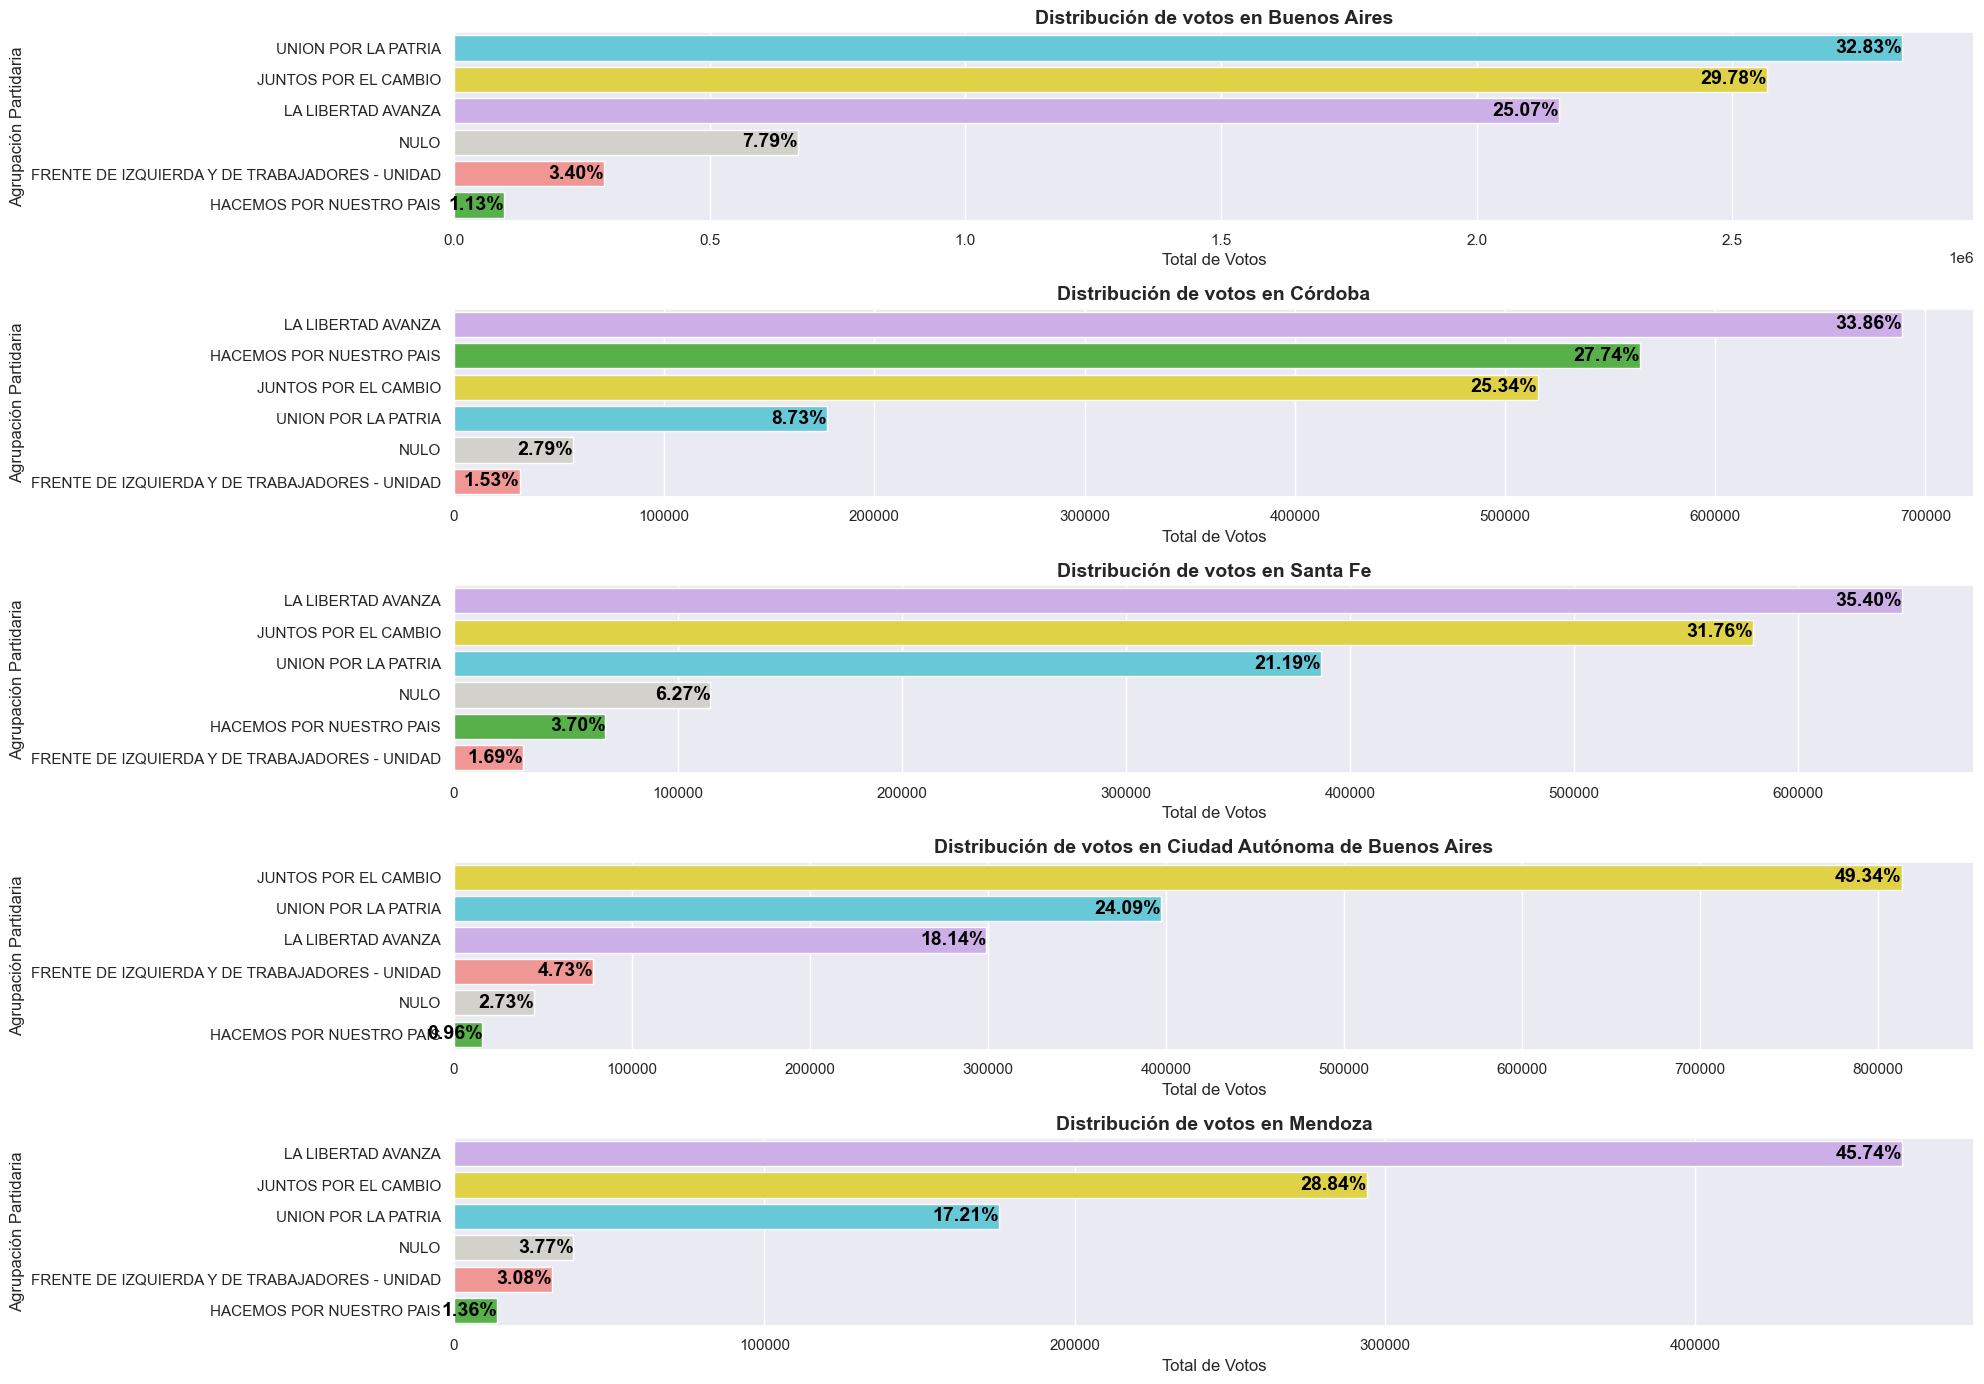

In [15]:

palette = {
    'NULO': '#d3d1cb',  # Color para etiqueta 'None'
    'JUNTOS POR EL CAMBIO': '#fae72c',
    'HACEMOS POR NUESTRO PAIS': '#4ac138',
    'LA LIBERTAD AVANZA': '#cda6f0',
    'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD': '#ff8986',
    'UNION POR LA PATRIA': '#54d5eb'
}

# Crea una figura con 5 subplots apilados verticalmente
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 14))

for index, p in enumerate(provincias_principales):
    # Filtra los datos para la provincia actual
    data = cantidad_votos_provincia_paso[cantidad_votos_provincia_paso['distrito_nombre'] == p]

    # Agrupa los datos por distrito y agrupación política y suma los votos
    d = data.groupby(['distrito_nombre', 'agrupacion_nombre']).sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
    total_votos_provincia = d['sum(votos_cantidad)'].sum()
    d['porcentaje'] = round((d['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)

    sns.barplot(data=d, x='sum(votos_cantidad)', y='agrupacion_nombre', ax=axes[index], palette=palette)

    # Configura títulos y etiquetas si es necesario
    axes[index].set_title(f'Distribución de votos en {p}', fontsize=14, weight='bold')
    axes[index].set_xlabel('Total de Votos')
    axes[index].set_ylabel('Agrupación Partidaria')

    for i, row in d.iterrows():
        porcentaje = row['porcentaje']
        axes[index].text(row['sum(votos_cantidad)'], i, f'{porcentaje:.2f}%', ha='right',va='center', fontsize=14, color='black', weight='bold')

plt.tight_layout()
plt.show()

Diferencia entre las PASO con las GENERALES

In [155]:
cantidad_votos_provincia_paso

,distrito_nombre,agrupacion_nombre,sum(votos_cantidad),porcentaje
0,Buenos Aires,UNION POR LA PATRIA,2831078,12.16
1,Salta,JUNTOS POR EL CAMBIO,111009,0.48
2,Salta,UNION POR LA PATRIA,155837,0.67
3,Santiago del Estero,UNION POR LA PATRIA,280563,1.20
4,Santiago del Estero,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,5606,0.02
...,...,...,...,...
139,"Tierra del Fuego, Antártida e Islas del Atlánt...",HACEMOS POR NUESTRO PAIS,4315,0.02
140,"Tierra del Fuego, Antártida e Islas del Atlánt...",NULO,7124,0.03
141,"Tierra del Fuego, Antártida e Islas del Atlánt...",FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,2703,0.01
142,"Tierra del Fuego, Antártida e Islas del Atlánt...",UNION POR LA PATRIA,29600,0.13


In [152]:
d# Agrupa los datos por distrito y agrupación política y suma los votos
d = data.groupby(['distrito_nombre', 'agrupacion_nombre']).sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
total_votos_provincia = d['sum(votos_cantidad)'].sum()
d['porcentaje'] = round((d['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)
d

,distrito_nombre,agrupacion_nombre,sum(votos_cantidad),porcentaje
0,Mendoza,LA LIBERTAD AVANZA,466437,45.74
1,Mendoza,JUNTOS POR EL CAMBIO,294077,28.84
2,Mendoza,UNION POR LA PATRIA,175522,17.21
3,Mendoza,NULO,38459,3.77
4,Mendoza,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,31452,3.08
5,Mendoza,HACEMOS POR NUESTRO PAIS,13858,1.36


---
# Dataset Elecciones GENERALES 2023

In [6]:
df_generales = spark.read.csv("ResultadosElectorales_2023_Generales.csv", header=True, inferSchema=True)

Me quedo unicamente con los datos de PRESIDENTE Y VICEPRESIDENTE

In [7]:
partidos = [
    'NULO',
    'JUNTOS POR EL CAMBIO',
    'HACEMOS POR NUESTRO PAIS',
    'LA LIBERTAD AVANZA',
    'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD',
    'UNION POR LA PATRIA'
]

# Los espacion None los relleno con NULO
df_generales = df_generales.fillna({'agrupacion_nombre':'NULO'})

# Me dejo los registros unicamente si la agrupacón esta dentro de los 5 partidos principales y que sean cargos de PRESIDENTE
df_generales_filtered = df_generales.filter((df_generales["agrupacion_nombre"].isin(partidos)) & (df_generales['cargo_nombre'] == 'PRESIDENTE Y VICE'))

In [18]:
df_generales_filtered.sample(False, 0.0010, seed=123).show()

+----+-------------+-------------+-----------+-----------+--------------------+--------------------+------------------------+----------+--------------+-----------+---------------+-------+---------+--------------+--------+-----------------+-------------+--------------------+------------+------------+----------+--------------+
| año|eleccion_tipo|recuento_tipo|padron_tipo|distrito_id|     distrito_nombre|seccionprovincial_id|seccionprovincial_nombre|seccion_id|seccion_nombre|circuito_id|circuito_nombre|mesa_id|mesa_tipo|mesa_electores|cargo_id|     cargo_nombre|agrupacion_id|   agrupacion_nombre|lista_numero|lista_nombre|votos_tipo|votos_cantidad|
+----+-------------+-------------+-----------+-----------+--------------------+--------------------+------------------------+----------+--------------+-----------+---------------+-------+---------+--------------+--------+-----------------+-------------+--------------------+------------+------------+----------+--------------+
|2023|      GENERAL

In [8]:
cantidad_votos_provincia_generales = df_generales_filtered.groupBy(
    ['distrito_nombre', 'agrupacion_nombre']).sum().select(
        ['distrito_nombre','agrupacion_nombre','sum(votos_cantidad)'])

cantidad_votos_provincia_generales = cantidad_votos_provincia_generales.toPandas()

In [31]:
cantidad_votos_provincia_generales.sample(5)

,distrito_nombre,agrupacion_nombre,sum(votos_cantidad)
54,La Rioja,HACEMOS POR NUESTRO PAIS,20179
93,La Pampa,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,5244
78,La Pampa,UNION POR LA PATRIA,79229
122,Santa Cruz,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,4948
84,Chaco,NULO,12966


In [9]:
generales = df_generales_filtered.toPandas()

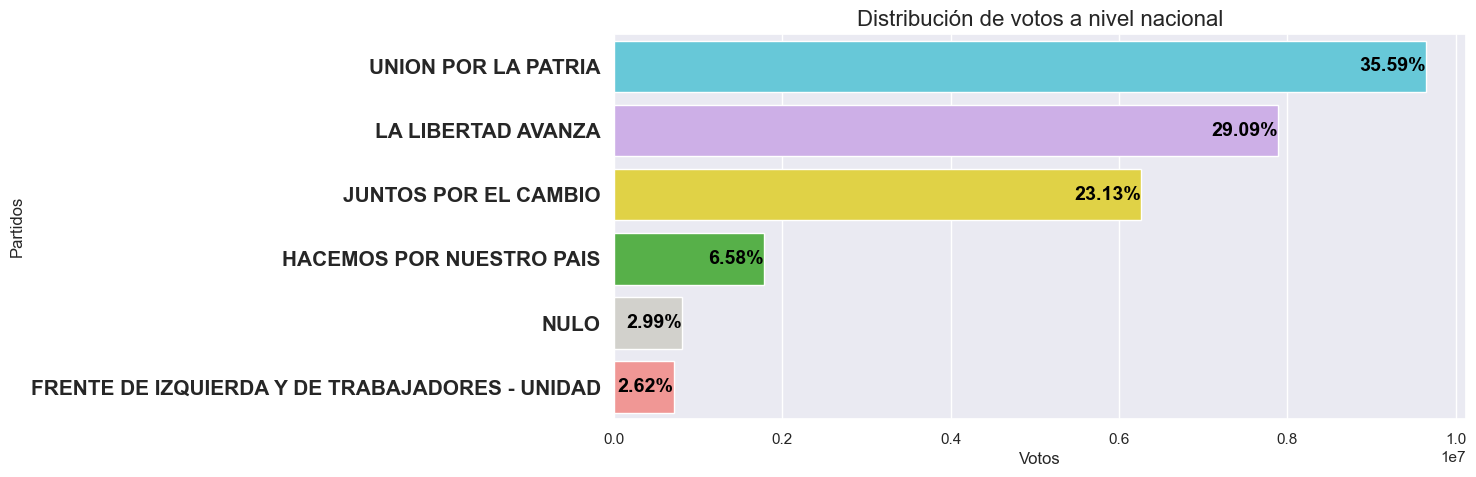

In [9]:
plt.figure(figsize=(11,5))

data = cantidad_votos_provincia_generales.groupby('agrupacion_nombre').sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
total_votos_provincia = data['sum(votos_cantidad)'].sum()
data['porcentaje'] = round((data['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)


ax = sns.barplot(data = data,
            x = 'sum(votos_cantidad)',
            y = 'agrupacion_nombre',
            errorbar=None, # en vez de ci=None,
            palette = palette)

# Agrega los porcentajes en las barras
for index, row in data.iterrows():
    porcentaje = row['porcentaje']
    ax.text(row['sum(votos_cantidad)'], index, f'{porcentaje:.2f}%', ha='right',va='center', fontsize=14, color='black', weight='bold')

plt.title('Distribución de votos a nivel nacional', fontsize=16)
plt.xlabel('Votos')
plt.ylabel('Partidos')
plt.yticks(fontsize=15, weight='bold')
plt.show()

### Comparacion de elecciones PASO y GENERALES

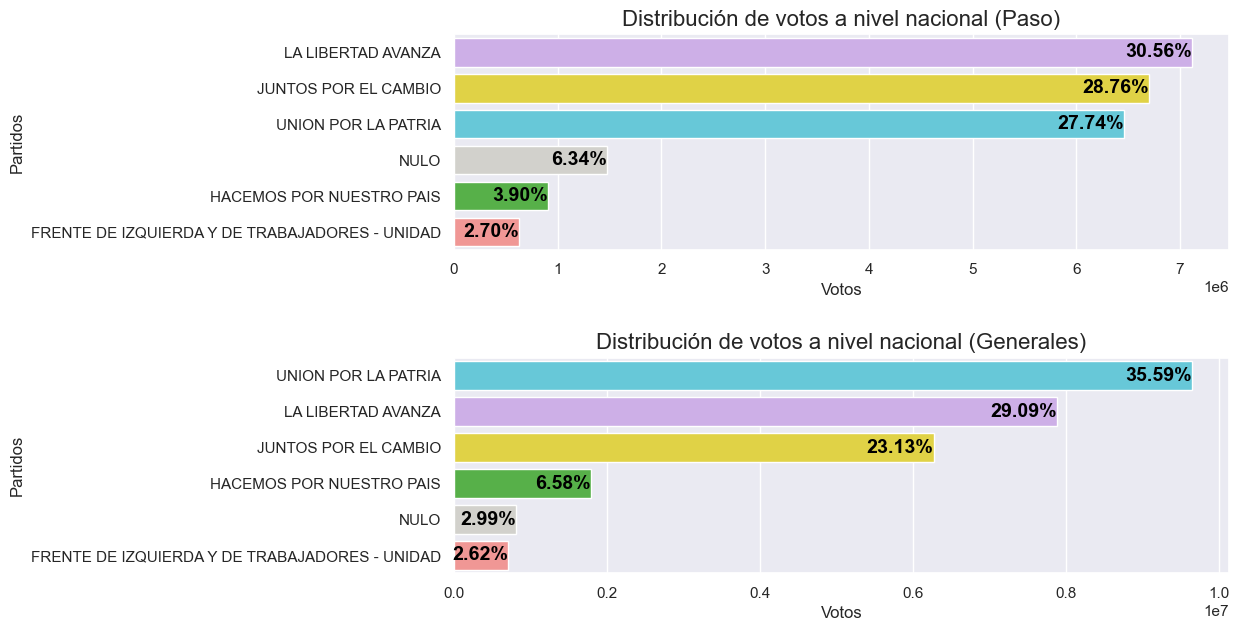

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
plt.subplots_adjust(hspace=0.5)

palette = {
    'NULO': '#d3d1cb',  # Color para etiqueta 'None'
    'JUNTOS POR EL CAMBIO': '#fae72c',
    'HACEMOS POR NUESTRO PAIS': '#4ac138',
    'LA LIBERTAD AVANZA': '#cda6f0',
    'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD': '#ff8986',
    'UNION POR LA PATRIA': '#54d5eb'
}

# Calcula los porcentajes para el primer gráfico
data = cantidad_votos_provincia_paso.groupby('agrupacion_nombre').sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
total_votos_provincia = data['sum(votos_cantidad)'].sum()
data['porcentaje'] = round((data['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)

# Primer gráfico
sns.barplot(data=data,
            x='sum(votos_cantidad)',
            y='agrupacion_nombre',
            errorbar=None,
            palette=palette,
            ax=axes[0])

# Agrega los porcentajes en las barras del primer gráfico
for index, row in data.iterrows():
    porcentaje = row['porcentaje']
    axes[0].text(row['sum(votos_cantidad)'], index, f'{porcentaje:.2f}%', ha='right', va='center', fontsize=14, color='black', weight='bold')

axes[0].set_title('Distribución de votos a nivel nacional (Paso)', fontsize=16)
axes[0].set_xlabel('Votos')
axes[0].set_ylabel('Partidos')

# Calcula los porcentajes para el segundo gráfico
data = cantidad_votos_provincia_generales.groupby('agrupacion_nombre').sum().sort_values(by='sum(votos_cantidad)', ascending=False).reset_index()
total_votos_provincia = data['sum(votos_cantidad)'].sum()
data['porcentaje'] = round((data['sum(votos_cantidad)'] / total_votos_provincia) * 100, 2)

# Segundo gráfico
sns.barplot(data=data,
            x='sum(votos_cantidad)',
            y='agrupacion_nombre',
            errorbar=None,
            palette=palette,
            ax=axes[1])

# Agrega los porcentajes en las barras del segundo gráfico
for index, row in data.iterrows():
    porcentaje = row['porcentaje']
    axes[1].text(row['sum(votos_cantidad)'], index, f'{porcentaje:.2f}%', ha='right', va='center', fontsize=14, color='black', weight='bold')

axes[1].set_title('Distribución de votos a nivel nacional (Generales)', fontsize=16)
axes[1].set_xlabel('Votos')
axes[1].set_ylabel('Partidos')

plt.show()

In [51]:
sde = df_generales_filtered.filter(df_generales_filtered['distrito_nombre'] == 'Santiago del Estero').toPandas()

In [53]:
sde.sort_values(by='votos_cantidad', ascending=False)

,año,eleccion_tipo,recuento_tipo,padron_tipo,distrito_id,distrito_nombre,seccionprovincial_id,seccionprovincial_nombre,seccion_id,seccion_nombre,circuito_id,circuito_nombre,mesa_id,mesa_tipo,mesa_electores,cargo_id,cargo_nombre,agrupacion_id,agrupacion_nombre,lista_numero,lista_nombre,votos_tipo,votos_cantidad
4880,2023,GENERAL,PROVISORIO,NORMAL,22,Santiago del Estero,0,None,12,Jiménez,00107,00107,1612,NATIVOS,348,1,PRESIDENTE Y VICE,134,UNION POR LA PATRIA,NaN,None,POSITIVO,283
11702,2023,GENERAL,PROVISORIO,NORMAL,22,Santiago del Estero,0,None,24,San Martín,00201,00201,2299,NATIVOS,319,1,PRESIDENTE Y VICE,134,UNION POR LA PATRIA,NaN,None,POSITIVO,277
6030,2023,GENERAL,PROVISORIO,NORMAL,22,Santiago del Estero,0,None,14,Juan F. Ibarra,00126,00126,1727,NATIVOS,352,1,PRESIDENTE Y VICE,134,UNION POR LA PATRIA,NaN,None,POSITIVO,271
4930,2023,GENERAL,PROVISORIO,NORMAL,22,Santiago del Estero,0,None,12,Jiménez,00107,00107,1617,NATIVOS,348,1,PRESIDENTE Y VICE,134,UNION POR LA PATRIA,NaN,None,POSITIVO,267
10171,2023,GENERAL,PROVISORIO,NORMAL,22,Santiago del Estero,0,None,22,Río Hondo,00191,00191,2144,NATIVOS,347,1,PRESIDENTE Y VICE,134,UNION POR LA PATRIA,NaN,None,POSITIVO,260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17236,2023,GENERAL,PROVISORIO,NORMAL,22,Santiago del Estero,0,None,1,Capital,0007B,0007B,388,NATIVOS,348,1,PRESIDENTE Y VICE,0,NULO,0.0,None,COMANDO,0
17237,2023,GENERAL,PROVISORIO,NORMAL,22,Santiago del Estero,0,None,1,Capital,0007B,0007B,389,NATIVOS,351,1,PRESIDENTE Y VICE,133,HACEMOS POR NUESTRO PAIS,NaN,None,POSITIVO,0
17238,2023,GENERAL,PROVISORIO,NORMAL,22,Santiago del Estero,0,None,1,Capital,0007B,0007B,389,NATIVOS,351,1,PRESIDENTE Y VICE,136,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,NaN,None,POSITIVO,0
17239,2023,GENERAL,PROVISORIO,NORMAL,22,Santiago del Estero,0,None,1,Capital,0007B,0007B,389,NATIVOS,351,1,PRESIDENTE Y VICE,134,UNION POR LA PATRIA,NaN,None,POSITIVO,0


In [69]:
paso_filtered.show(10)

+----+-------------+-------------+-----------+-----------+---------------+--------------------+------------------------+----------+--------------+-----------+---------------+-------+---------+--------------+--------+------------+-------------+--------------------+------------+--------------------+----------+--------------+
| año|eleccion_tipo|recuento_tipo|padron_tipo|distrito_id|distrito_nombre|seccionprovincial_id|seccionprovincial_nombre|seccion_id|seccion_nombre|circuito_id|circuito_nombre|mesa_id|mesa_tipo|mesa_electores|cargo_id|cargo_nombre|agrupacion_id|   agrupacion_nombre|lista_numero|        lista_nombre|votos_tipo|votos_cantidad|
+----+-------------+-------------+-----------+-----------+---------------+--------------------+------------------------+----------+--------------+-----------+---------------+-------+---------+--------------+--------+------------+-------------+--------------------+------------+--------------------+----------+--------------+
|2023|         PASO|   PR

In [73]:
paso_sde = paso_filtered.filter(paso_filtered['distrito_nombre'] == 'Santiago del Estero').toPandas()
generales_sde = df_generales_filtered.filter(df_generales_filtered['distrito_nombre'] == 'Santiago del Estero').toPandas()

<Axes: xlabel='mesa_electores', ylabel='votos_cantidad'>

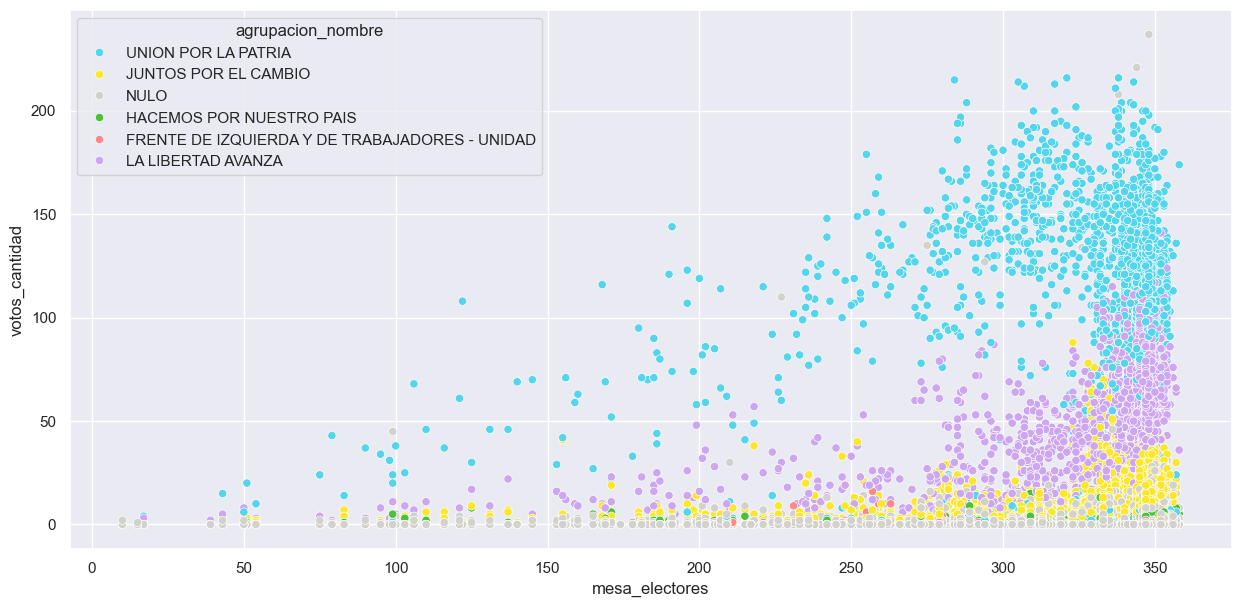

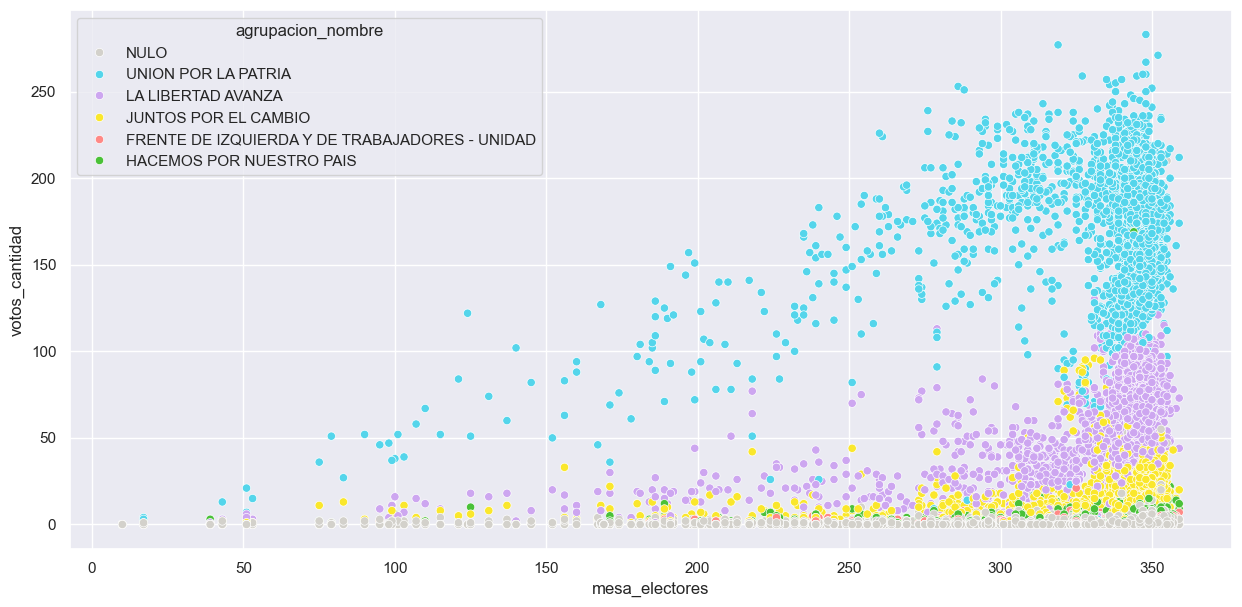

In [74]:
plt.figure(figsize=(15,7))
sns.scatterplot(data = paso_sde, y = 'votos_cantidad', x = 'mesa_electores', hue='agrupacion_nombre', palette=palette)

plt.figure(figsize=(15,7))
sns.scatterplot(data = generales_sde, y = 'votos_cantidad', x = 'mesa_electores', hue='agrupacion_nombre', palette=palette)


<Axes: xlabel='mesa_id', ylabel='votos_cantidad'>

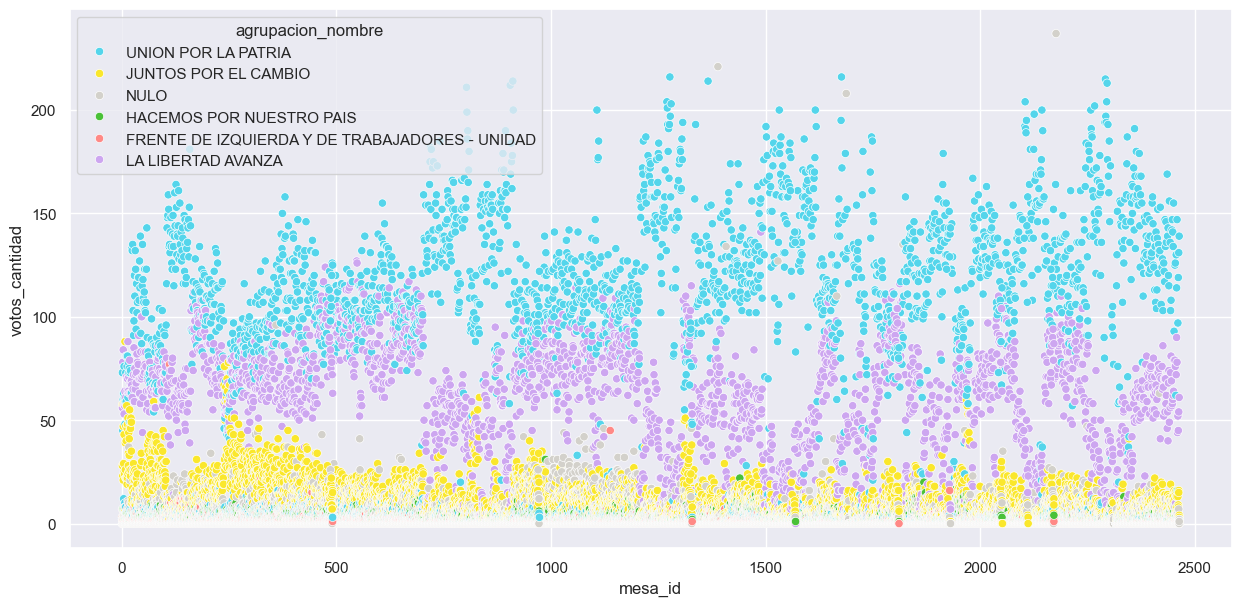

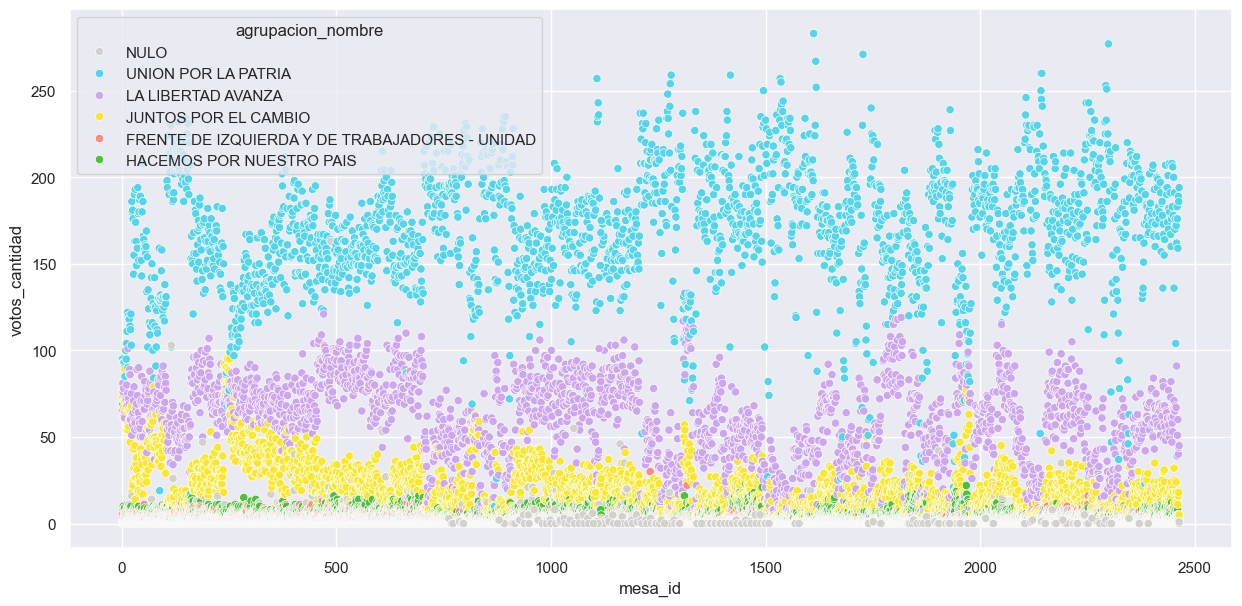

In [75]:
plt.figure(figsize=(15,7))
sns.scatterplot(data = paso_sde, y = 'votos_cantidad', x = 'mesa_id', hue='agrupacion_nombre', palette=palette)

plt.figure(figsize=(15,7))
sns.scatterplot(data = generales_sde, y = 'votos_cantidad', x = 'mesa_id', hue='agrupacion_nombre', palette=palette)


Reconfiguro de nuevo la columna de "mesa_id" para que queden valores unicos para cada mesa

In [10]:
generales['mesa_id'] = generales['distrito_id'].astype(str) + generales['circuito_nombre'].astype(str) + generales['mesa_id'].astype(str)

In [11]:
generales_filtered = generales.copy()

In [12]:
generales_filtered = generales_filtered.drop(columns={'año','eleccion_tipo','recuento_tipo','padron_tipo',
                                 'circuito_id','cargo_id','agrupacion_id','lista_numero',
                                 'lista_nombre','distrito_id','seccionprovincial_nombre','seccion_id','seccion_nombre',
                                 'circuito_nombre','mesa_tipo','cargo_nombre','votos_tipo'})

In [13]:
generales_filtered.sample(5)

,distrito_nombre,seccionprovincial_id,mesa_id,mesa_electores,agrupacion_nombre,votos_cantidad
679533,Formosa,0,90000379,349,NULO,0
697623,Chaco,0,6000621384,348,HACEMOS POR NUESTRO PAIS,4
772101,Río Negro,0,1600011283,337,NULO,26
34695,Ciudad Autónoma de Buenos Aires,0,1000521685,338,JUNTOS POR EL CAMBIO,37
344918,Buenos Aires,1,200891270,349,HACEMOS POR NUESTRO PAIS,8


In [14]:
votos_x_mesa = generales_filtered.groupby(by=['mesa_id','agrupacion_nombre','distrito_nombre']).sum().reset_index()

In [15]:
votos_x_mesa['mesa_id'].drop_duplicates().count()

104520

Ahora quiero ver un grafico provincia por provincia como fue la distribución de votos en las mesas

In [ ]:
provincia = 'Córdoba'

In [ ]:
plt.figure(figsize=(12,7))
sns.scatterplot(data = votos_x_mesa[votos_x_mesa['distrito_nombre'] == provincia].sample(5000), x = 'mesa_id', y = 'votos_cantidad', hue = 'agrupacion_nombre')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002167B2CE200> (for post_execute):


KeyboardInterrupt: 

In [16]:
votos_x_mesa[votos_x_mesa['distrito_nombre'] == 'Córdoba'].loc[votos_x_mesa['mesa_id'].isin(['4000011','40397A9082'])]

,mesa_id,agrupacion_nombre,distrito_nombre,seccionprovincial_id,mesa_electores,votos_cantidad
500304,4000011,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,Córdoba,0,344,8
500305,4000011,HACEMOS POR NUESTRO PAIS,Córdoba,0,344,46
500306,4000011,JUNTOS POR EL CAMBIO,Córdoba,0,344,84
500307,4000011,LA LIBERTAD AVANZA,Córdoba,0,344,69
500308,4000011,NULO,Córdoba,0,1720,4
500309,4000011,UNION POR LA PATRIA,Córdoba,0,344,45
554880,40397A9082,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,Córdoba,0,3,0
554881,40397A9082,HACEMOS POR NUESTRO PAIS,Córdoba,0,3,0
554882,40397A9082,JUNTOS POR EL CAMBIO,Córdoba,0,3,0
554883,40397A9082,LA LIBERTAD AVANZA,Córdoba,0,3,0


In [23]:
mesas = ['4000011', '40000110', '40000111', '40000112', '40000113',
       '40000114', '40000115', '40000116', '40000117', '40000118',
       '40000119', '4000012', '40000120', '40000121', '40000122',
       '40000123', '40000124', '40000125', '40000126', '40000127',
       '40000128', '40000129', '4000013', '40000130', '40000131',
       '40000132', '40000133', '40000134', '40000135', '40000136',
       '40000137', '40000138', '40000139', '4000014', '40000140',
       '40000141', '40000142', '40000143', '40000144', '40000145']

In [28]:
palette = {
    'NULO': '#d3d1cb',  # Color para etiqueta 'None'
    'JUNTOS POR EL CAMBIO': '#fae72c',
    'HACEMOS POR NUESTRO PAIS': '#4ac138',
    'LA LIBERTAD AVANZA': '#cda6f0',
    'FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD': '#ff8986',
    'UNION POR LA PATRIA': '#54d5eb'
}
plt.figure(figsize=(15,6))
sns.scatterplot(data = votos_x_mesa[votos_x_mesa['distrito_nombre'] == 'Córdoba'],
                x = 'mesa_id',
                y = 'votos_cantidad',
                hue = 'agrupacion_nombre',
                palette = palette)
plt.xticks(rotation=90)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000029143196CB0> (for post_execute):


KeyboardInterrupt: 

In [29]:
votos_x_mesa

,mesa_id,agrupacion_nombre,distrito_nombre,seccionprovincial_id,mesa_electores,votos_cantidad
0,10000011,FRENTE DE IZQUIERDA Y DE TRABAJADORES - UNIDAD,Jujuy,0,328,6
1,10000011,HACEMOS POR NUESTRO PAIS,Jujuy,0,328,16
2,10000011,JUNTOS POR EL CAMBIO,Jujuy,0,328,52
3,10000011,LA LIBERTAD AVANZA,Jujuy,0,328,88
4,10000011,NULO,Jujuy,0,1640,8
...,...,...,...,...,...,...
627115,90084C1484,HACEMOS POR NUESTRO PAIS,Formosa,0,331,0
627116,90084C1484,JUNTOS POR EL CAMBIO,Formosa,0,331,33
627117,90084C1484,LA LIBERTAD AVANZA,Formosa,0,331,17
627118,90084C1484,NULO,Formosa,0,1655,2


In [30]:
votos_x_mesa['total_votos'] = votos_x_mesa.groupby('mesa_id')['votos_cantidad'].transform('sum')

In [31]:
votos_x_mesa['porcentaje'] = (votos_x_mesa['votos_cantidad'] / votos_x_mesa['total_votos']) * 100

In [39]:
votos_x_mesa.loc[votos_x_mesa['porcentaje'] > 90].drop_duplicates(subset='mesa_id')

,mesa_id,agrupacion_nombre,distrito_nombre,seccionprovincial_id,mesa_electores,votos_cantidad,total_votos,porcentaje
65141,120034B764,UNION POR LA PATRIA,La Rioja,0,33,14,15,93.333333
66035,120062C953,UNION POR LA PATRIA,La Rioja,0,85,60,66,90.909091
141173,170029A2828,UNION POR LA PATRIA,Salta,0,315,206,221,93.212670
141185,170029A2830,UNION POR LA PATRIA,Salta,0,316,177,192,92.187500
141257,170029C2842,UNION POR LA PATRIA,Salta,0,333,175,193,90.673575
...,...,...,...,...,...,...,...,...
624419,9000591232,UNION POR LA PATRIA,Formosa,0,21,1,1,100.000000
625217,9000791383,UNION POR LA PATRIA,Formosa,0,100,36,39,92.307692
626777,90060A1251,UNION POR LA PATRIA,Formosa,0,11,1,1,100.000000
626873,90065A1280,UNION POR LA PATRIA,Formosa,0,19,3,3,100.000000


In [67]:
votos_x_mesa['mesa_varianza'] = votos_x_mesa.groupby(['mesa_id'])['votos_cantidad'].transform('var')

In [75]:
min = votos_x_mesa['mesa_varianza'].min()
max = votos_x_mesa['mesa_varianza'].max()
median = votos_x_mesa['mesa_varianza'].median()
mean = votos_x_mesa['mesa_varianza'].mean()

print(min, max, median, mean)

0.0 14902.566666666666 1927.6 2085.515978122208


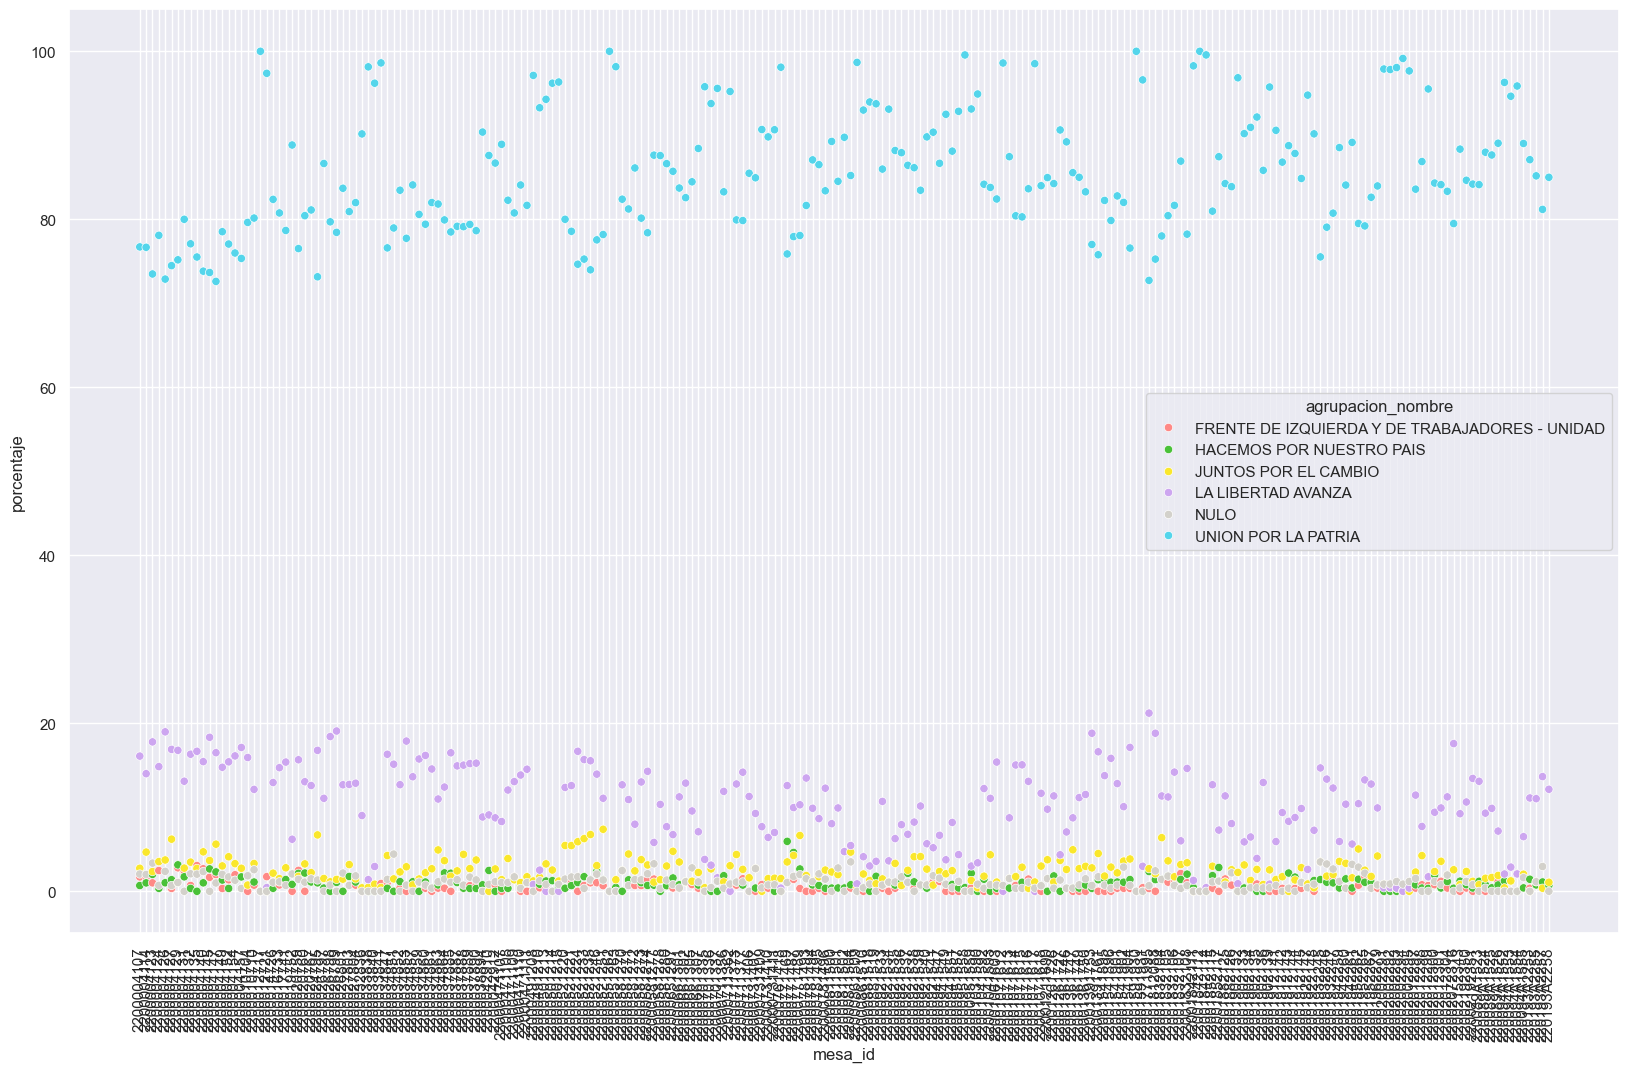

In [94]:
plt.figure(figsize=(20,12))
data = votos_x_mesa.loc[(votos_x_mesa['distrito_nombre'] == 'Santiago del Estero') & (votos_x_mesa['mesa_varianza'] > 7000)]
sns.scatterplot(data = data,
                x = 'mesa_id',
                y = 'porcentaje',
                hue = 'agrupacion_nombre', 
                palette = palette)
plt.xticks(rotation=90)
plt.show()

Muestro las mesas que tiene mas del 95% de votos de UNION POR LA PATRIA

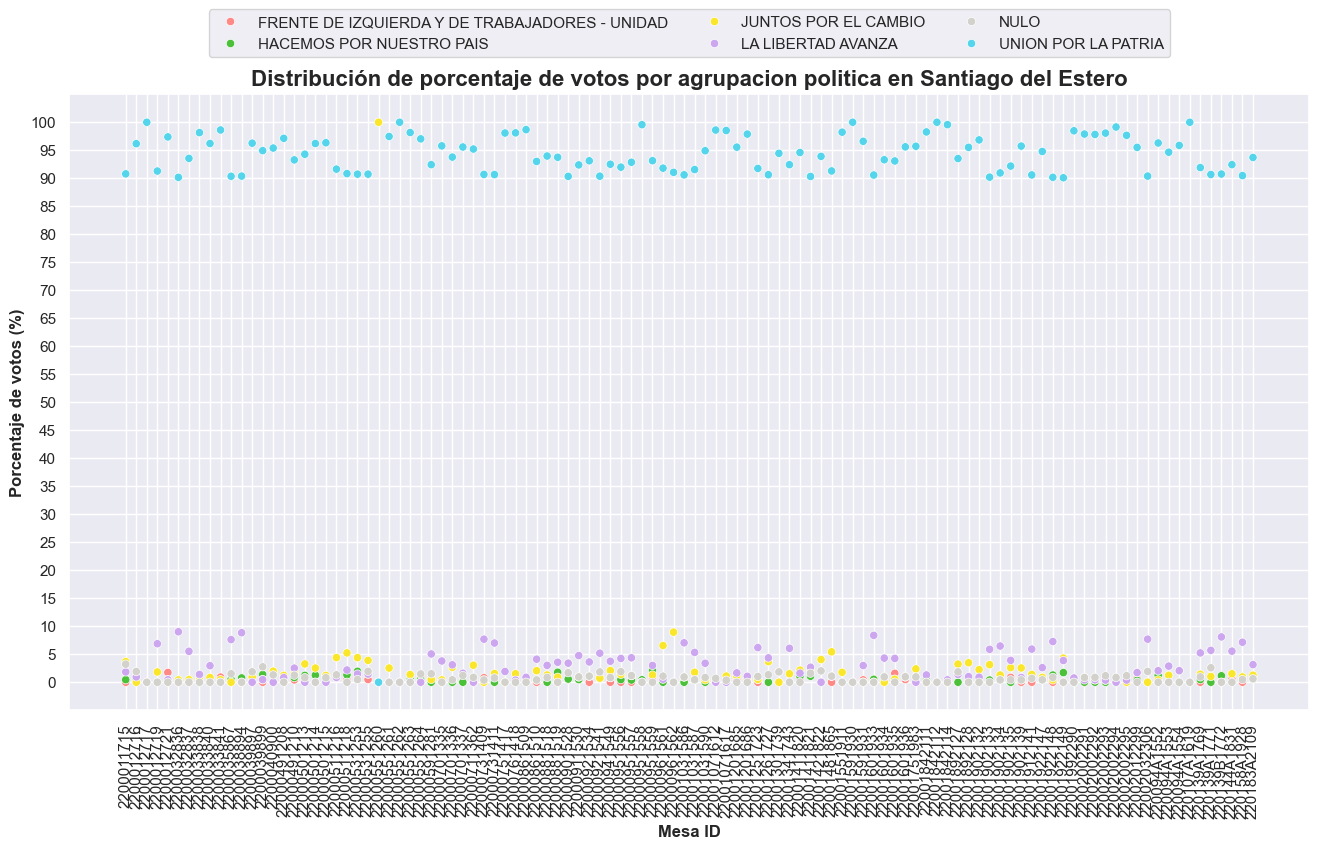

In [163]:
provincia = 'Santiago del Estero'
porcentaje = 90

data = votos_x_mesa.loc[votos_x_mesa['distrito_nombre'] == provincia]
mesas_fraude = data[data['porcentaje'] > porcentaje].drop_duplicates(subset='mesa_id')['mesa_id'].to_list()
data = data[data['mesa_id'].isin(mesas_fraude)]

if len(data) > 100:
    plt.figure(figsize=(16,8))
else:
    plt.figure(figsize=(10,8))

sns.scatterplot(data = data,
                x = 'mesa_id',
                y = 'porcentaje',
                hue = 'agrupacion_nombre', 
                palette = palette,
                alpha = 1)
plt.xticks(rotation=90)
plt.xlabel('Mesa ID', weight='bold', fontsize=12)
plt.ylabel('Porcentaje de votos (%)', weight='bold', fontsize=12)
plt.yticks(range(0,105,5))
plt.legend(loc='upper center', ncols=3, bbox_to_anchor=(0.5, 1.15))
plt.title(f'Distribución de porcentaje de votos por agrupacion politica en {provincia}', fontsize=16, weight='bold')
plt.show()

In [154]:
len(data.drop_duplicates(subset='mesa_id'))

108